In [7]:
%load_ext autoreload
%autoreload 2

from model_utils import train_model, split_data
from config import Config
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import os
import datasets
import torch
from model_manager import ModelManager

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
seed = random.randint(0, 2 ** 32 - 1)
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 561100887


In [9]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

eval_lines: 
train_lines: PlayerReply c "Hey, Remy!" DragonReply Ry "Hello, [player_name]."
PlayerReply c "Is there any particular reason why you wanted to meet here?" DragonReply Ry "I enjoy Tatsu Park is all. Have you been here before?"
PlayerReply c "Can't say I have." PlayerReply c "A few times." PlayerReply c "Once or twice." DragonReply Ry "I see." DragonReply Ry "Well, what do you think of it?"
PlayerReply c "It's pretty idyllic." DragonReply Ry smile "It is. I like it a lot here."
PlayerReply c "It's pretty romantic." DragonReply Ry shy "You think so?"


In [10]:
config = {
    "model_name": "EleutherAI/gpt-neo-125M",
    "lr": 6e-4,
    "warmup_factor": 2,
    "scheduler": "polynomial_decay_schedule_with_warmup",
    "lr_end": 2e-6,
    "power": 0.6,
#     "freeze_layer_rate": 1e-4,
    "freeze_from_steps": -1,
    "seed": seed,
    "num_epoch": 50,
    "to_freeze_count": 0
}

In [12]:
train_results = {}
train_model(config, train_results, device = device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Token indices sequence length is longer than the specified maximum sequence length for this model (2515 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2334 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2265 > 2048). Running this sequence through the model will result in indexing errors
***** Running training *****
  Num examples = 2027
  Num Epochs = 50
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation step

[0] set freeze_part_layers: True (freezing 0 out of 160 layers.)


Step,Training Loss
250,2.176600
500,1.006100
750,0.473500
1000,0.232500
1250,0.132400
1500,0.084400
1750,0.047700
2000,0.027300
2250,0.022600
2500,0.022800


Saving model checkpoint to /opt/awsw/models/awsw_main/checkpoint-500
Configuration saved in /opt/awsw/models/awsw_main/checkpoint-500/config.json
Model weights saved in /opt/awsw/models/awsw_main/checkpoint-500/pytorch_model.bin
Saving model checkpoint to /opt/awsw/models/awsw_main/checkpoint-1000
Configuration saved in /opt/awsw/models/awsw_main/checkpoint-1000/config.json
Model weights saved in /opt/awsw/models/awsw_main/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to /opt/awsw/models/awsw_main/checkpoint-1500
Configuration saved in /opt/awsw/models/awsw_main/checkpoint-1500/config.json
Model weights saved in /opt/awsw/models/awsw_main/checkpoint-1500/pytorch_model.bin
Deleting older checkpoint [/opt/awsw/models/awsw_main/checkpoint-500] due to args.save_total_limit
Saving model checkpoint to /opt/awsw/models/awsw_main/checkpoint-2000
Configuration saved in /opt/awsw/models/awsw_main/checkpoint-2000/config.json
Model weights saved in /opt/awsw/models/awsw_main/checkpoint

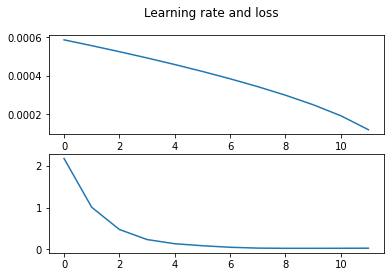

In [13]:
fig, axs = plt.subplots(2)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['loss_history'])

# Testing

We created a few past (for context) + present prompts (player input) and see the different reactions. This way, we can test the models across different iterations.

In [14]:
train_results['model'].eval()
model_manager = ModelManager(model=train_results['model'], tokenizer=train_results['tokenizer'])

In [16]:
prompts = [
    ('PlayerReply c "Hey Remy!" DragonReply Ry "Hey!"', "How are you?"),
    ('PlayerReply c "I was with Lorem today." DragonReply Ad "Very nice."', "What do you think of Lorem?"),
    ('DragonReply m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('DragonReply m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
]

for (past, prompt) in prompts:
    reply = model_manager.say(past, prompt)
    print(f"Prompt: {prompt}\nReply: {reply}\n\n")

Prompt: How are you?
Reply: Ry "I'm quite happy to hear that you're doing well, thanks."<|endoftext|>


Prompt: What do you think of Lorem?
Reply: Lo think "I don't know. I'm not sure if I can take any visitors at the moment."<|endoftext|>


Prompt: Oh my god, Adine. What is this?
Reply: Ad "It's a constant struggle - I don't think I can ever make it out to them." DragonReply Ad "If you can't find the exit, I'll give you some good reason why you would argue that it's not so bad that it's all public. That's not to say, it's public. That's what everyone wants."<|endoftext|>


Prompt: What will we do here?
Reply: m "She looked at me with a mild expression of bewilderment."<|endoftext|>




# Sampling test

Which combination is the best?

In [ ]:
for i in range(100):
    torch.manual_seed(80085)
    top_k = random.randint(0, 100)
    top_p = round(random.uniform(0, 1), 2)
    for (past, prompt) in prompts:
        reply = model_manager.say(past, prompt, top_k = top_k, top_p = top_p)
        print(f"[Test {i + 1} top_k: {top_k}, top_p: {top_p}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-------------")

[Test 1 top_k: 11, top_p: 1.0] -> Prompt: How are you?
Reply: Ry "I'm quite well, thanks to the police. I didn't want to go on a date with you in the first place."<|endoftext|>

[Test 1 top_k: 11, top_p: 1.0] -> Prompt: What do you think of Lorem?
Reply: Lo think "I don't know, maybe I shouldn't say that. But he was such a braveer who gave up his life in order to save me." DragonReply Lo normal "Someone had to." DragonReply Lo think "Maybe I should just walk on the two of you."<|endoftext|>

[Test 1 top_k: 11, top_p: 1.0] -> Prompt: Oh my god, Adine. What is this?
Reply: Ad "It's a constant struggle - for example, when I have to fight by accident." DragonReply Ad "When I fight by accident, I can usually just let it go."<|endoftext|>

[Test 1 top_k: 11, top_p: 1.0] -> Prompt: What will we do here?
Reply: m "She looked at me with a mild expression of bewilderment."<|endoftext|>

-------------
[Test 2 top_k: 44, top_p: 0.62] -> Prompt: How are you?
Reply: Ry "I'm quite well, thanks to the

In [ ]:
model_manager = ModelManager(checkpoint_dirs[-1])
print("What to say?")
print(generate_dragon_reply("", input()))